## Setting up the Notebook

In [70]:
#Setting up the notebook

import sys
print('Python version {}'.format(sys.version)) #3.9.7 
import pandas as pd  # version 1.3.4
import numpy as np # 1.20.3
import seaborn as sns # version 0.11.2
import matplotlib.pyplot as plt # version 3.4.3
import matplotlib.dates as mdates # version 3.4.3
from sklearn.ensemble import IsolationForest  # sklearn version 0.24.2
import scipy.stats as stats # version 1.7.1
from scipy.stats import ks_2samp # scipy.stats version 1.7.1
from scipy.stats import normaltest # scipy.stats version 1.7.1

Python version 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


## Loading the dataset

In [71]:
df = pd.read_csv('WQexecutiontest.csv')  
print(df.shape) # looking at the shape of the dataset
df.head()

(5915, 4)


,trading_date,exchange_id,traded_volume,pnl
0,8/2/2018,1,751,-154455.70040
1,8/3/2018,1,899,79136.32718
2,8/6/2018,1,1019,-188857.47110
3,8/7/2018,1,711,-57418.19247
4,8/8/2018,1,981,-48853.60456



# Part 1: Preliminary Analysis

## Investigating data (looking at data types, missing values, and descriptive statistics)

In [72]:
#checking the type of each column
df.dtypes # all column data types look reasonable (I will convert 'trading_date' variable to datetime later in the notebook)

trading_date      object
exchange_id        int64
traded_volume      int64
pnl              float64
dtype: object

In [73]:
#checking for any missing values 
df.isnull().sum() # no missing values

trading_date     0
exchange_id      0
traded_volume    0
pnl              0
dtype: int64

In [74]:
# Looking at descriptive statistics of the dataset
df.describe() # 'traded_volume' variable has some zero values, which we want to investigate further

,exchange_id,traded_volume,pnl
count,5915.000000,5915.000000,5.915000e+03
mean,6.506340,841.679797,2.030503e+03
std,3.772856,1213.164212,3.721712e+05
min,1.000000,0.000000,-6.554183e+06
25%,3.000000,85.000000,-4.197581e+04
50%,6.000000,408.000000,0.000000e+00
75%,10.000000,1224.000000,3.380820e+04
max,13.000000,17382.000000,6.358621e+06


In [75]:
# Looking at instances when 'traded_volume' was 0 and 'pnl' was not 0
df[(df['traded_volume'] == 0) & (df['pnl'] != 0)]

,trading_date,exchange_id,traded_volume,pnl
80,11/22/2018,1,0,61867.541430
357,12/16/2019,1,0,228107.271200
606,11/22/2018,2,0,95857.560270
1033,7/13/2020,2,0,529482.228600
1132,11/22/2018,3,0,4961.778375
...,...,...,...,...
4668,1/8/2020,10,0,7119.227176
4674,1/16/2020,10,0,15111.031140
4685,1/31/2020,10,0,2450.933945
4856,7/1/2020,11,0,-118.526095


There are 80 instances of 0 'trading_volume' and non-zero 'pnl'. One possible explanation is that a position was carried from a day before, but this should be investigated further. For now, I am going to leave these instances in the dataset. There are 196 instances of 0 'trading_volume' and 0 'pnl'.

In [76]:
# Looking at exchange IDs for any additional information regarding 0 trading volume and non-zero pnl
df[(df['traded_volume'] == 0) & (df['pnl'] != 0)]['exchange_id'].value_counts() 

10    48
3     18
1      2
2      2
4      2
5      2
6      1
7      1
8      1
9      1
11     1
13     1
Name: exchange_id, dtype: int64

Exchange 10 accounts for majority of 0 'trading_volume' and non-zero 'pnl' instances (48). Exchange 3 also accounts for a large number of instances (18). No such instances in exchange 12

## Distribution of the pnl variable

[Text(0.5, 1.0, 'PnL distribution')]

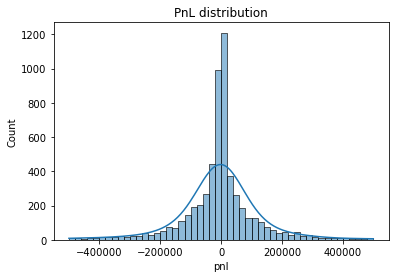

In [77]:
sns.histplot(data = df['pnl'], binrange = (-500000, 500000), binwidth = 20000, kde = True, kde_kws={"clip":(-500000,500000)}).set(title='PnL distribution')

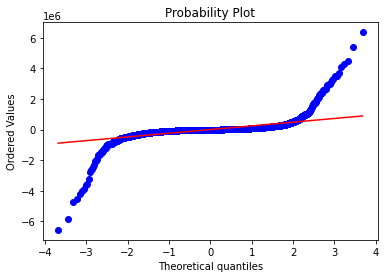

In [78]:
stats.probplot(df['pnl'], dist="norm", plot=plt)
plt.show()

Distribution of the PnL variable does not look normal - it is more heavily concentrated around the mean than a normal distribution and the QQ plot also shows there is a number of outliers.

## Investigating Daily and Cumulative PnL

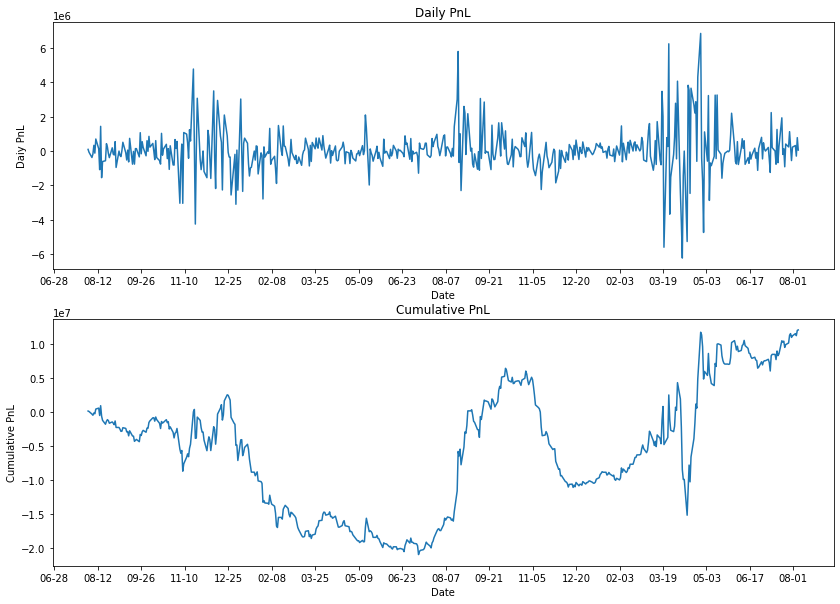

In [79]:
## Investigating pnl by day
pnl_by_day = pd.DataFrame(df.groupby('trading_date').pnl.sum()) 
# Converting the index as date
pnl_by_day.index = pd.to_datetime(pnl_by_day.index)
pnl_by_day = pnl_by_day.sort_index()
pnl_by_day.columns = ['Daily PnL']
pnl_by_day['Cumulative PnL'] = pnl_by_day['Daily PnL'].cumsum()

fig, ax = plt.subplots(2,1, figsize=(14,10))
sns.lineplot(data = pnl_by_day['Daily PnL'], ax=ax[0])
days = mdates.DayLocator(interval=45)
days_fmt = mdates.DateFormatter('%m-%d')
ax[0].set_title("Daily PnL")
ax[0].set_ylabel("Daiy PnL")
ax[0].set_xlabel("Date")
ax[0].xaxis.set_major_locator(days)
ax[0].xaxis.set_major_formatter(days_fmt)

sns.lineplot(data =  pnl_by_day['Cumulative PnL'], ax=ax[1])
ax[1].set_title("Cumulative PnL")
ax[1].set_ylabel("Cumulative PnL")
ax[1].set_xlabel("Date")
ax[1].xaxis.set_major_locator(days)
ax[1].xaxis.set_major_formatter(days_fmt)
plt.show()

Observations: 1) There are periods of high Daily PnL volatility, particularly from mid-March of 2020 to mid-May of 2020. This would align with an increase in volatility associated with the start of the pandemic.

2) Cumulative PnL was declining in the first half of the dataset, then began growing. There are large fluctuations in cumulative PnL, particularly in the 2nd half of the dataset (aligned with big swings in daily PnL)

## Investigating Daily Traded Volume

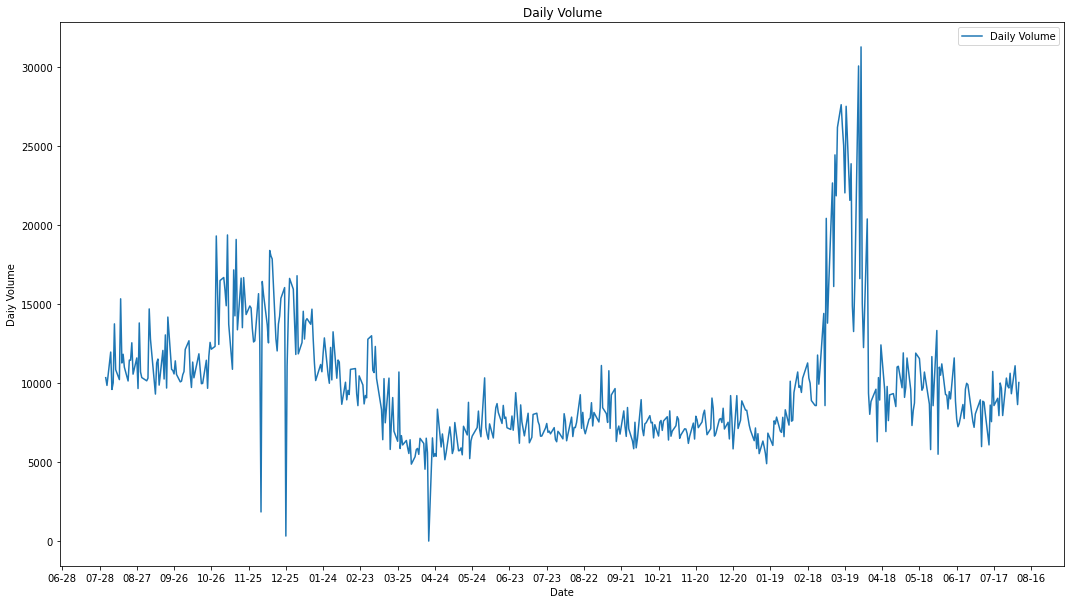

In [80]:
## Volume by day
volume_by_day = pd.DataFrame(df.groupby('trading_date').traded_volume.sum()) 
# Converting the index as date
volume_by_day.index = pd.to_datetime(volume_by_day.index)
volume_by_day = volume_by_day.sort_index()
volume_by_day.columns = ['Daily Volume']

fig, ax = plt.subplots(figsize=[18, 10])
sns.lineplot(data = volume_by_day[volume_by_day['Daily Volume']!=0], ax = ax) #looking at non-zero volume days
days = mdates.DayLocator(interval=30)
days_fmt = mdates.DateFormatter('%m-%d')
ax.set_title("Daily Volume")
ax.set_ylabel("Daiy Volume")
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_fmt)
ax.xaxis.set_major_formatter(days_fmt)
plt.show()

Observations: There is a large spike in daily volume from the end of February 2020 to mid-April 2020, which aligns with an increase in market volatility associated with the start of the pandemic

# Part 2: Investigating traded_volume and pnl by exchange_id

## Creating traded_volume and pnl dataframes separated by exchange_id

In [81]:
traded_volume = df.reset_index().pivot(index='trading_date', columns='exchange_id', values='traded_volume')
traded_volume.index = pd.to_datetime(traded_volume.index)
traded_volume = traded_volume.sort_index()

pnl = df.reset_index().pivot(index='trading_date', columns='exchange_id', values='pnl')
pnl.index = pd.to_datetime(pnl.index)
pnl = pnl.sort_index()

#Normalizing pnl across each exchange
normalized_pnl = pnl.apply(lambda x: (x - np.mean(x)) / np.std(x) , axis = 0)
transformed_k2, transformed_p = normaltest(normalized_pnl)
print(transformed_p)

[6.95605066e-016 7.52908136e-022 1.94565574e-091 2.93259436e-049
 4.08932925e-114 1.99211474e-050 6.53494753e-048 1.28904685e-035
             nan             nan             nan             nan
 2.82563839e-051]


very small p-values (<0.001) indicate the transformed pnl data across each exchange follows a normal distribution. However, I will continue to use original pnl data as we are mostly interested in finding anomalies in the original dataset

## Looking into a 'traded_volume' variable grouped by exchange_id

In [82]:
df.groupby('exchange_id').traded_volume.describe()

,count,mean,std,min,25%,50%,75%,max
exchange_id,,,,,,,,
1,526.0,1843.825095,2203.721219,0.0,807.75,1233.0,1927.75,17382.0
2,526.0,2045.557034,1102.745825,0.0,1368.50,1747.0,2393.25,6996.0
3,526.0,27.756654,56.182540,0.0,5.00,11.5,25.00,703.0
4,526.0,1079.477186,616.529354,0.0,670.00,933.0,1330.50,3803.0
5,526.0,414.032319,289.032845,0.0,246.25,348.5,490.75,2261.0
6,526.0,293.733840,193.514329,0.0,171.25,256.0,373.00,2029.0
7,526.0,1588.756654,1304.133296,0.0,829.25,1145.5,1898.75,8031.0
8,526.0,194.024715,208.808888,0.0,82.25,147.5,224.50,2349.0
9,174.0,20.804598,18.453089,0.0,7.25,15.5,29.00,99.0


traded_volume appears to be split into 3 relatively distinct groups - Exchanges 1, 2, 4, 7, 13  have considerably more trading volume than others (median greater than 900), Exchanges 3, 9, 10, and 11 have considerably less traded volume than others (median less than 16), and
Exchanges 5, 6, 8, and 12 are in the middle.

Most exchanges have 526 observations, with the exception of exchange 11 (63 observations), exchange 9 (174 observations), exchange 10 (438 observations), and exchange 12 (506 observations). 

<AxesSubplot:xlabel='exchange_id'>

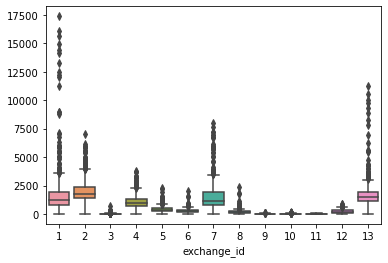

In [83]:
sns.boxplot(data = traded_volume)

Looking at std and boxplots, big variability in traded_volume for exchange 1 (and, to a smaller degree, for exchanges 13, 7, and 2)

(1.0, 6000.0)

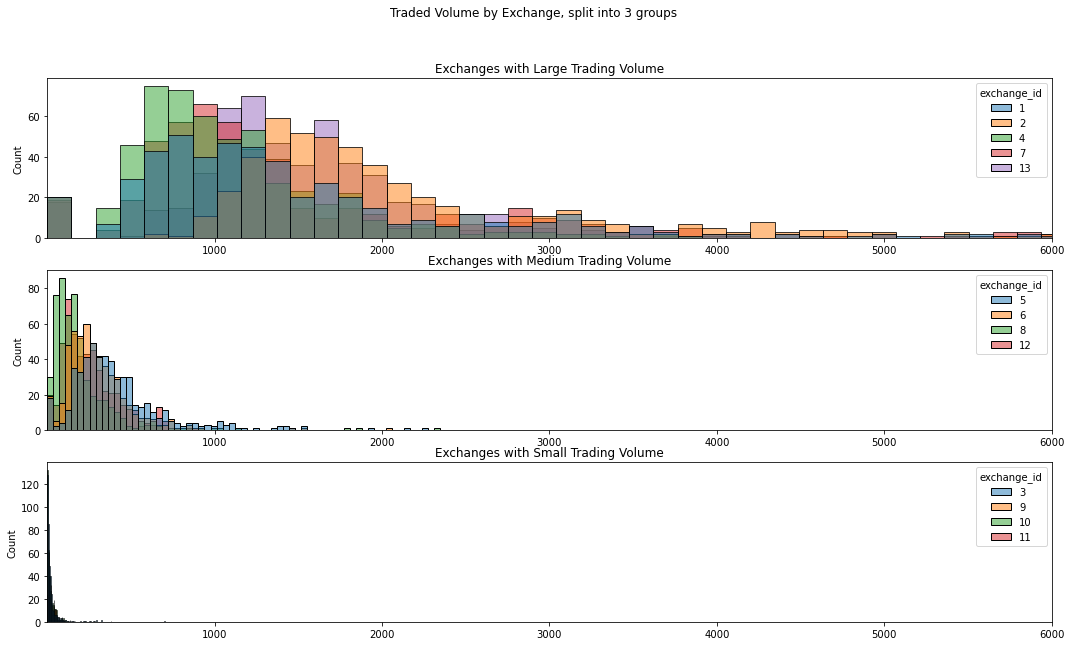

In [84]:
# Splitting traded volume into 3 exchange groups from above
fig, axes = plt.subplots(3, 1, figsize=(18, 10))
fig.suptitle('Traded Volume by Exchange, split into 3 groups')
sns.histplot(ax=axes[0], data=traded_volume[[1,2, 4, 7, 13]]).set(title='Exchanges with Large Trading Volume')
axes[0].set_xlim(1, 6000)
sns.histplot(ax=axes[1], data=traded_volume[[5, 6, 8, 12]]).set(title='Exchanges with Medium Trading Volume')
axes[1].set_xlim(1, 6000)
sns.histplot(ax=axes[2], data=traded_volume[[3, 9, 10, 11]]).set(title='Exchanges with Small Trading Volume')
axes[2].set_xlim(1, 6000)

Charts support the idea that distributions of trading volumes are different across these 3 groups of exchanges


## Looking into a 'pnl' variable grouped by exchange_id

In [85]:
df.groupby('exchange_id').pnl.describe()
df.groupby('exchange_id').pnl.describe()[['mean', '25%', '50%', '75%']] 

,mean,25%,50%,75%
exchange_id,,,,
1,3838.645595,-96620.003668,0.000000,87774.722467
2,4126.285957,-321993.831025,-46184.029360,202445.074775
3,395.762164,-6798.592602,856.901041,9234.689012
4,13119.597480,-111215.620950,0.000000,125363.236700
5,7939.054181,-50262.740838,-760.993455,47886.391850
6,5683.056967,-61248.294905,0.000000,54613.059095
7,-16430.038889,-92328.545335,-14627.775420,65395.461740
8,-1238.139618,-34136.638927,-1450.945827,24792.163105
9,-416.369704,-2643.117014,-97.465885,828.308418


<AxesSubplot:xlabel='exchange_id'>

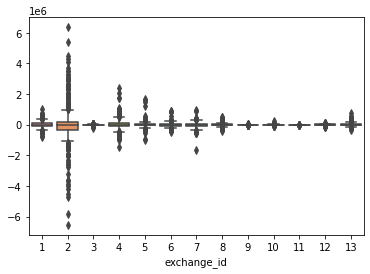

In [86]:
sns.boxplot(data = pnl)

There is large variability in exchange 2 pnl (seemingly with lots of outliers). 
It is worth investigating why median pnl for exchange 2 is -46,184. Likewise, median pnl for exchange 7 (and to a degree, exchange 13) is also worth investigating.

Exchanges 1 and 13, which had the most traded volume variability, does not show the same level of variability in pnl

## Investigating exchange 2 pnl futher - creating a scatterplot of traded_volume and pnl, split by exchange 2 vs the rest

C:\Users\DMITRI~1\AppData\Local\Temp/ipykernel_7032/3708115564.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exchange2'][df2['exchange_id']== 2] = 1


<AxesSubplot:xlabel='traded_volume', ylabel='pnl'>

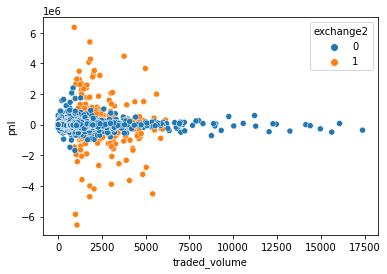

In [87]:
# one hypothesis is that exchange 2's pnl variability is associated with traded volumes
df2 = df
df2['exchange2'] = 0
df2['exchange2'][df2['exchange_id']== 2] = 1
sns.scatterplot(x = 'traded_volume', y = 'pnl', hue="exchange2", data=df2)

Dispersion of exchange 2 points looks significantly different vs the rest, which supports an earlier observation that trading at exchange 2 is different from other exchanges



## Running a Kolmogorov-Smirnov test to compare pnl distributions of exchange 2 vs other exchanges


In [88]:
exchange_2_pnl=df[df['exchange_id']==2]['pnl'].values.tolist()
other_exchanges_pnl=df[df['exchange_id']!=2]['pnl'].values.tolist()

ks_2samp(exchange_2_pnl, other_exchanges_pnl)

KstestResult(statistic=0.3295972573338028, pvalue=1.1102230246251565e-16)

low p-value indicates that we can reject the null hypothesis that both distributions are the same. This result indicates that pnl distribution generated from exchange 2 is different from the pnl distribution generated from other exchanges

## Finding ('traded_volume', 'pnl') anomalies using Isolation Forest model

<AxesSubplot:xlabel='exchange_id'>

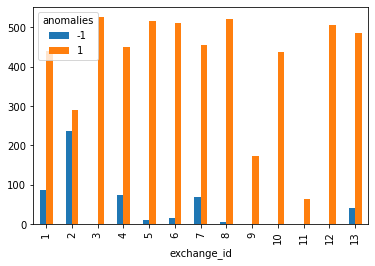

In [89]:
#Using Isolation Forest model to find outliers in data
clf = IsolationForest(max_samples=250, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(df[['traded_volume', 'pnl']])
#preds
df_preds = pd.Series(preds, index = df2.index, name = 'anomalies')
df2 = pd.concat([df2, df_preds], axis = 1)
#df2.groupby('exchange_id').anomalies.value_counts()
df2.groupby('exchange_id').anomalies.value_counts().unstack().plot.bar()

Exchange 2 has a large number of ('traded_volume', 'pnl') anomalies, which further agrees with earlier charts and observations

## Looking at extreme pnl observations

In [90]:
df[(df['pnl'] > 1500000) | (df['pnl'] < -1500000)]

,trading_date,exchange_id,traded_volume,pnl,exchange2
593,11/5/2018,2,4834,-3249016.769,1
596,11/8/2018,2,5030,-2783404.250,1
603,11/19/2018,2,3769,4473581.532,1
605,11/21/2018,2,4072,-3649580.480,1
607,11/23/2018,2,2382,3214029.450,1
...,...,...,...,...,...
2029,4/24/2020,4,775,2068732.903,0
2040,5/11/2020,4,1285,1750466.303,0
2523,3/11/2020,5,213,1583786.296,0
2538,4/1/2020,5,311,1653575.440,0


In [91]:
df[(df['pnl'] > 1500000) | (df['pnl'] < -1500000)].groupby('exchange_id')['traded_volume'].describe()

,count,mean,std,min,25%,50%,75%,max
exchange_id,,,,,,,,
2,58.0,2297.706897,1323.407762,916.0,1328.50,1797.5,3061.0,5620.0
4,4.0,971.250000,224.847170,775.0,831.25,912.5,1052.5,1285.0
5,2.0,262.000000,69.296465,213.0,237.50,262.0,286.5,311.0
7,1.0,954.000000,NaN,954.0,954.00,954.0,954.0,954.0


Majority of extreme pnl observations happen on exchange 2. Exchange 2 does have the biggest volumes (on average); however, there are other exchanges with high volumes that do not see similarly large pnl fluctuations (such as exchanges 1 and 13). 

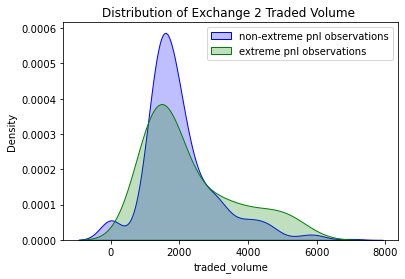

In [92]:
# Comparing Exchange 2 extreme and non-extreme pnl observations (using 1500000 as a cutoff, which is about 11% of exchange 2 observations)
exchange_2_extreme =  df[( (df['pnl'] > 1500000) | (df['pnl'] < -1500000)) & (df['exchange_id'] == 2) ]
exchange_2_non_extreme = df[ (df['pnl'] < 1500000) & (df['pnl'] >= -1500000) & (df['exchange_id'] == 2) ]

f, ax = plt.subplots(1,1)
sns.kdeplot(data = exchange_2_non_extreme['traded_volume'],  color="blue", label="non-extreme pnl observations", fill = True)
sns.kdeplot(data=exchange_2_extreme['traded_volume'], color="green", label="extreme pnl observations", fill = True)
ax.set_title('Distribution of Exchange 2 Traded Volume ')
ax.legend()

Distributions of traded volume on exchange 2 (for extreme pnl observations vs non-extreme pnl observations) are not much different and it is worth investigating further what happened on those days when exchange 2 saw large pnl fluctuations


## Plotting historical time-series for traded_volume and pnl

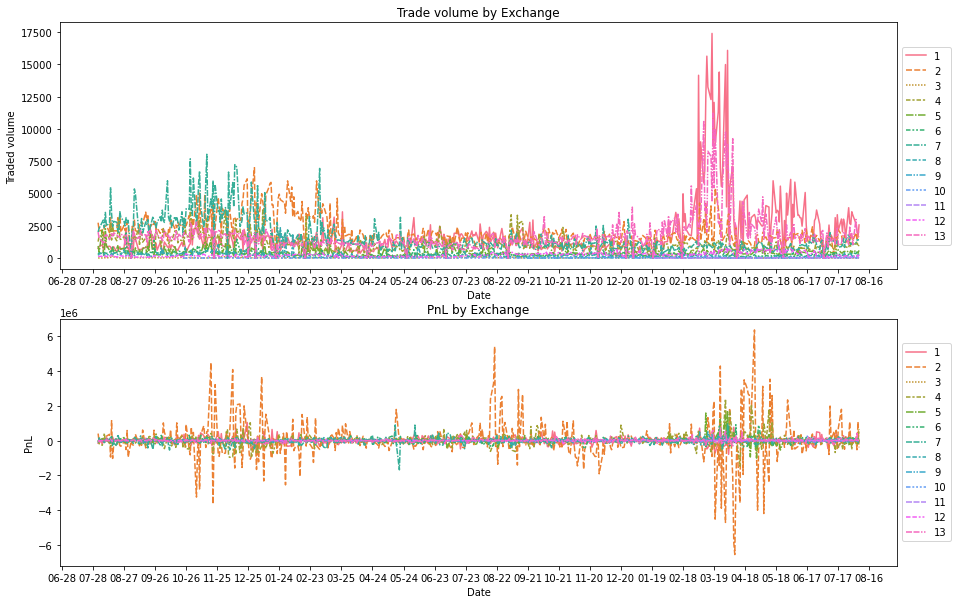

In [93]:
# line plots of trade volume and pnl by exchange
fig, ax = plt.subplots(2, 1, figsize=(15,10))
sns.lineplot(data = traded_volume, ax=ax[0])
days = mdates.DayLocator(interval=30)
days_fmt = mdates.DateFormatter('%m-%d')
ax[0].set_title("Trade volume by Exchange")
ax[0].set_ylabel("Traded volume")
ax[0].set_xlabel("Date")
ax[0].xaxis.set_major_locator(days)
ax[0].xaxis.set_major_formatter(days_fmt)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.lineplot(data = pnl, ax=ax[1])
ax[1].set_title("PnL by Exchange")
ax[1].set_ylabel("PnL")
ax[1].set_xlabel("Date")
ax[1].xaxis.set_major_locator(days)
ax[1].xaxis.set_major_formatter(days_fmt)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Observations:
1) There is a big spike in trading activity from mid-February 2020 through the end of March 2020, for exchanges 1 and 13.This spike is in line with increased market volatility at the start of the pandemic.

2) Exchange 2 has large fluctuations in pnl around this time - there 
is some increase in trading volume for Exchange 2 from mid-February 2020 through the end of March 2020, but it is not as large as it is for exchanges 1 and 13. Exchange 2 appears to have large pnl fluctuations throughout the entire time-series and those big fluctuations should be investigated further.

# Part 3: Investigating pnl / traded_volume


## Creating pnl_per_volume dataframe split by exchange_id

C:\Users\DMITRI~1\AppData\Local\Temp/ipykernel_7032/2308926770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['pnl_per_volume'] = new_df['pnl'] / new_df['traded_volume']


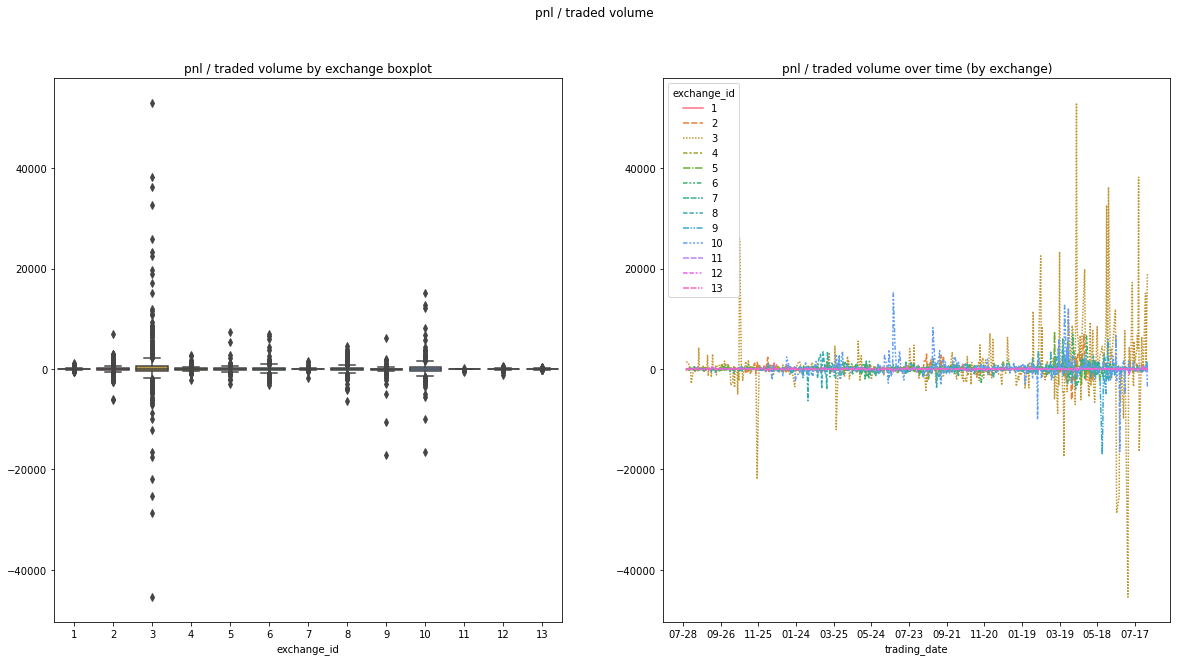

In [94]:
new_df = df[df['traded_volume']!=0] #excluding observations with 0 traded volume
new_df['pnl_per_volume'] = new_df['pnl'] / new_df['traded_volume']
pnl_per_volume = new_df.reset_index().pivot(index='trading_date', columns='exchange_id', values='pnl_per_volume') #creating new dataframe separated by exchange
pnl_per_volume.index = pd.to_datetime(pnl_per_volume.index)
pnl_per_volume = pnl_per_volume.sort_index()

fig, axes = plt.subplots(1,2, figsize=(20, 10))
fig.suptitle('pnl / traded volume')
days = mdates.DayLocator(interval=60)
days_fmt = mdates.DateFormatter('%m-%d')
sns.boxplot(ax = axes[0], data = pnl_per_volume).set(title = 'pnl / traded volume by exchange boxplot')
sns.lineplot(ax = axes[1], data = pnl_per_volume).set(title = 'pnl / traded volume over time (by exchange)')
axes[1].xaxis.set_major_locator(days)
axes[1].xaxis.set_major_formatter(days_fmt) 

Big dispersion of (pnl / traded volume) at exchange 3.
In addition, exchange 3 has spikes of (pnl / traded volume) volatility throughout the time-series, particularly after mid-February 2020

## Subsetting (pnl / traded volume) to find extreme observations

In [95]:
new_df[(new_df['pnl_per_volume'] > 10000) | (new_df['pnl_per_volume'] < -10000)]

,trading_date,exchange_id,traded_volume,pnl,exchange2,pnl_per_volume
1113,10/26/2018,3,1,25958.85833,0,25958.858330
1133,11/23/2018,3,2,-43869.23859,0,-21934.619295
1223,3/29/2019,3,1,-12062.13994,0,-12062.139940
1447,2/6/2020,3,1,11456.37982,0,11456.379820
1455,2/18/2020,3,1,22520.34616,0,22520.346160
1477,3/19/2020,3,3,70047.02403,0,23349.008010
1482,3/26/2020,3,1,-17438.87394,0,-17438.873940
1487,4/2/2020,3,1,10905.43694,0,10905.436940
1496,4/15/2020,3,1,52948.64239,0,52948.642390
1505,4/28/2020,3,1,19782.30961,0,19782.309610


In [96]:
new_df[(new_df['pnl_per_volume'] > 10000) | (new_df['pnl_per_volume'] < -10000)].groupby('exchange_id')['traded_volume'].value_counts()

exchange_id  traded_volume
3            1                15
             2                 3
             3                 3
             7                 1
9            1                 1
             2                 1
10           4                 2
             2                 1
             6                 1
             7                 1
Name: traded_volume, dtype: int64

Most of extreme (pnl / traded volume) observations happen on exchange 3 and are due to days with only 1, 2, or 3 trades (and large pnls associated with those trades). 
From earlier observations, exchange 3 did have small traded volumes, but there are other exchanges that also had small trading volumes that did not have such extreme (pnl /trading volume) observations - thus, these (pnl / traded volume) anomalies on exchange 3 are worth investigating further. Most of extreme observations happen in 2020, between early February and late July.

## Running a Kolmogorov-Smirnov test to compare (pnl / traded volume) distributions of exchange 3 vs other exchanges

In [97]:
exchange_3_pnl_volume=new_df[new_df['exchange_id']==3]['pnl_per_volume'].values.tolist()
other_exchanges_pnl_volume=new_df[new_df['exchange_id']!=3]['pnl_per_volume'].values.tolist()

ks_2samp(exchange_3_pnl_volume, other_exchanges_pnl_volume)

KstestResult(statistic=0.2459329848787122, pvalue=2.1119829708196112e-24)

low p-value indicates that we can reject the null hypothesis that both distributions are the same. This result indicates that (pnl / traded volume) distribution generated from exchange 3 is different from the (pnl / traded volume) distribution generated from other exchanges